C:\Users\MUSIC\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\colors.py:715: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


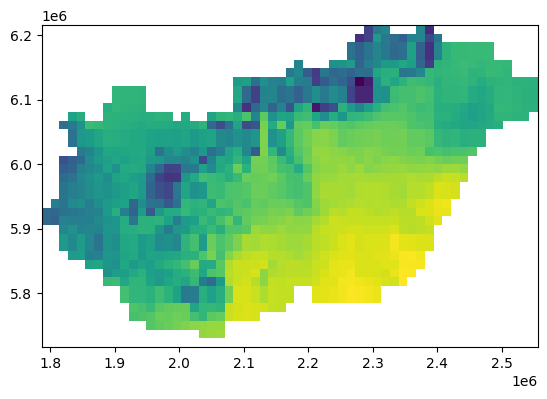

<AxesSubplot: >

In [19]:
import main as m
import rasterio as rs
from rasterio.plot import show
inp = 'RCM_ta_20112040_ann_p_1_HU.tif'
inp = 'OBS_ta_19912020_JJA_o_0_HU.tif'
inp = 'too-hot-days-19912020_ann_o_0_HU.tif'
#fp = r'inp'
img = rs.open(inp)
show(img)

In [21]:
### CHATGPT
import rasterio
import geopandas as gpd
from rasterio.features import shapes

# Load the GeoTIFF file into a Rasterio dataset object
with rasterio.open(inp) as src:
    dataset = src.read(1)
    transform = src.transform
    crs = src.crs

# Extract the values from the raster as a list of shapes and values
shapes = shapes(dataset, transform=transform)

shapeRaw = []
for i in shapes:
    shapeRaw.append(i)

# Convert the list of shapes and values to a GeoPandas GeoDataFrame
# gdf = gpd.GeoDataFrame.from_features(shapes, crs=crs)
# gdf = gpd.GeoDataFrame.from_features(shapeRaw, crs=crs)

# Drop any missing or invalid values
# gdf.dropna(inplace=True)

# y is a value
# x is a polygon
polygons = []
values = []
data = []
for x,y in shapeRaw:
    l = []
    l.append(x['coordinates'])
    #print(i['coordinates'])
    #print(i['type'])
    l.append(y)
    data.append(l)
df = m.pd.DataFrame(data, columns=['geometry', 'value'])
# depemnds on, some values could be integers, some of the floats. Should be checked. 
df.value = df.value.round(1) # rounding values 
#df.value = df.value.astype(int) # integer save space, float = not
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=[m.Polygon(x[0]) for x in df['geometry']])
t = gdf.to_crs({'init': 'epsg:4326'}) #4326 works since https://epsg.io/?q=4326
t = t[t.value > min(t.value)]

C:\Users\MUSIC\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [22]:
import folium
import matplotlib
import mapclassify
t.explore("value", cmap="YlGn")